# 参考下面的网络结构图片  
Reference: https://blog.csdn.net/leviopku/article/details/82660381
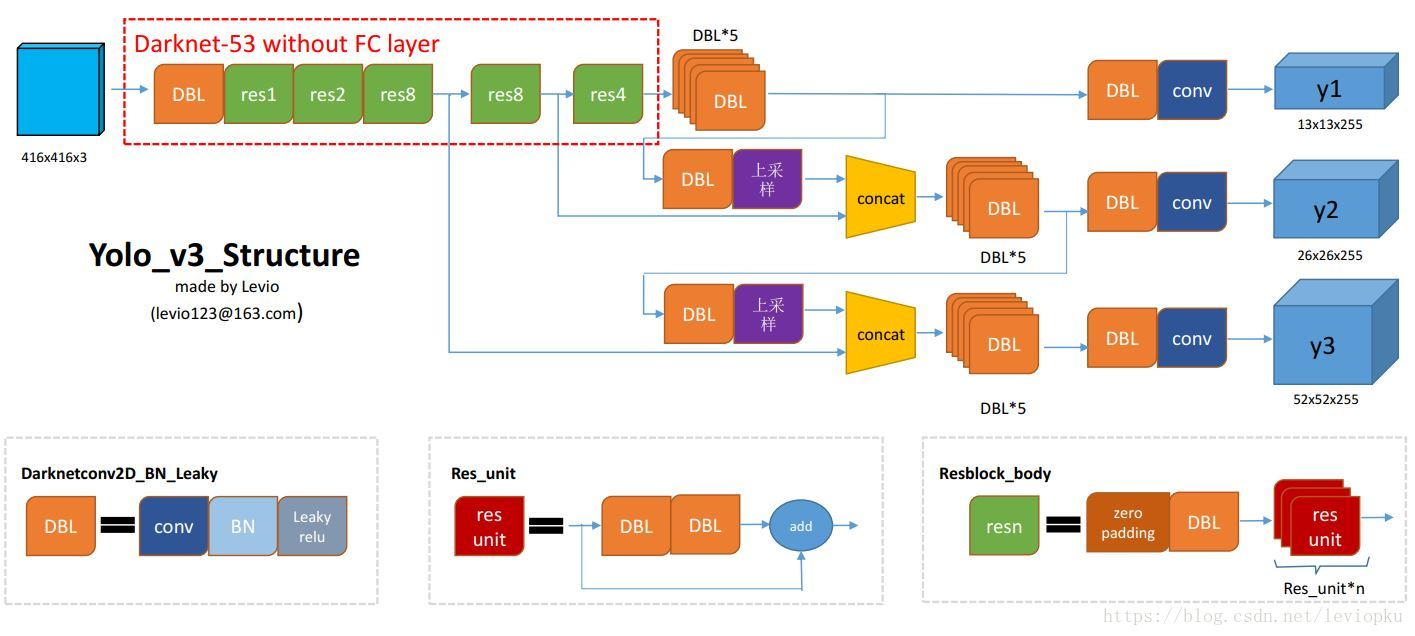

In [1]:
import numpy as np
import os
import sys
import scipy
import cv2
import gc

#解析使用
import xml
from xml.etree import ElementTree as ET

from glob import glob

import keras.backend as K
from keras.applications import VGG19
from keras.models import Model
from keras.utils import to_categorical

import imageio
from skimage import transform

from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.svm import SVC #类别分类使用
from sklearn.linear_model import Ridge #bounding-box回归
from sklearn.externals import joblib

C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import tensorflow as tf

from tensorflow.contrib import slim

In [3]:
import warnings

warnings.filterwarnings(action='error')

In [4]:
TRAIN_DATA_PATH = '../../../tensorflow2/dataset/VOCtrainval_11-May-2012/JPEGImages/'
TEST_DATA_PATH = '../../../tensorflow2/dataset/VOC2012test/JPEGImages/'

TRAIN_XML_PATH = '../../../tensorflow2/dataset/VOCtrainval_11-May-2012/Annotations/'
TEST_XML_PATH = '../../../tensorflow2/dataset/VOC2012test/Annotations/'

CLASSES_NUM = 20

STR = [
    'person',
    'bird','cat','cow','dog','horse','sheep',
    'aeroplane','bicycle','boat','bus','car','motorbike','train',
    'bottle','chair','diningtable','pottedplant','sofa','tvmonitor'
]

LABEL2STR = {idx:value for idx , value in enumerate(STR)}
STR2LABEL = {value:key for key,value in LABEL2STR.items()}
#STR2LABEL = {value:idx for idx , value in enumerate(STR)}

STR2LABEL['none'] = 'none' #先不使用part部分 只进行naive目标检测

#目标检测相关
IoU_THRESHOLD = 0.5

#SVM相关
SVM_IoU_THRESHOLD = 0.3

#NMS相关
NMS_IoU_THRESHOLD = 0.3 #or ~0.5

#bbox回归
BBOX_REGRESS_IoU_THRESHOLD = 0.6

In [5]:
xml_file_names_train = glob(TRAIN_XML_PATH + '*') #所有的xml文件 完整路径

#从xml文件中读出图片相关的信息

def xml_parse(xml_file):
    '''
    return filename , shape , name_boxes , crop_boxes
    xml文件中的shape格式为 (width height 3)
    '''
    xml_file = xml.dom.minidom.parse(xml_file)
    xml_file_docu_ele = xml_file.documentElement

    filename_list = xml_file_docu_ele.getElementsByTagName('filename')
    
    #filename_list可能有多个filename的 所以要索引0(此数据集中filename只有一个)
    filename = filename_list[0].childNodes[0].data #filename_list.firstChild.data

    #图像的尺寸信息
    size_list = xml_file_docu_ele.getElementsByTagName('size')

    for size in size_list:
        width_list = size.getElementsByTagName('width')
        width = int(width_list[0].childNodes[0].data)

        height_list = size.getElementsByTagName('height')
        height = int(height_list[0].childNodes[0].data)

        channel_list = size.getElementsByTagName('depth')
        channel = int(channel_list[0].childNodes[0].data)

    #一个文件中有多个object
    object_list = xml_file_docu_ele.getElementsByTagName('object')

    #多个object与多个object对应的详细信息
    name_boxes = [] #一个元素就是一个object
    crop_boxes = []

    for objects in object_list:
        #一次循环处理一个object信息
        #一个xml文件（即一个图像中）有多个object

        #name
        name_list = objects.getElementsByTagName('name')

        name_box = name_list[0].childNodes[0].data

        #bounding box points
        bndbox = objects.getElementsByTagName('bndbox')

        x1_list = bndbox[0].getElementsByTagName('xmin')
        x1 = int( round( float(x1_list[0].childNodes[0].data) ) )

        y1_list = bndbox[0].getElementsByTagName('ymin')
        y1 = int(round(float( y1_list[0].childNodes[0].data )))

        x2_list = bndbox[0].getElementsByTagName('xmax')
        x2 = int(round(float( x2_list[0].childNodes[0].data )))

        y2_list = bndbox[0].getElementsByTagName('ymax')
        y2 = int(round(float( y2_list[0].childNodes[0].data )))

        crop_box = [x1,x2,y1,y2]

        name_boxes.append(name_box)
        crop_boxes.append(crop_box)

    #crop_box:[x1 x2 y1 y2]
    return filename , name_boxes , np.array(crop_boxes) #filename调试使用


In [6]:
#xml_parse(xml_file_names_train[897])

In [7]:
class Image(object):
    '''
    图片的真实信息
    '''
    def __init__(self):
        self.img_file_names_train = glob(TRAIN_DATA_PATH+'*') #训练全路径信息
                
    def load(self , img_path_name = None):
        if not img_path_name:
            img_path_name = np.random.choice(self.img_file_names_train) #随机选择一张图片
            #img_path_idx = np.random.randint(0 , high = len(self.img_file_names_train)) #随机索引

        img_arr = cv2.imread(img_path_name) #BGR height*width*chanel
        
        xml_file_name = TRAIN_XML_PATH + img_path_name[-15:-4] +  '.xml'
        
        _ , name_boxes , crop_boxes = xml_parse(xml_file_name)
        
        labels = [] #存储与bndbox对应的 label信息

        for i in range(len(crop_boxes)): #多个object 
            labels.append(STR2LABEL.get(name_boxes[i] , 'none'))
        
        return img_arr , labels , crop_boxes
    

In [8]:
def display(image , pred_boxes , name):    
    im_h = image.shape[0]
    im_w = image.shape[1]
    
    output = image.copy()
    
    for box in pred_boxes:
        overlay = output.copy()
        
        class_idx = np.argmax(box[5:])
        
        x_min , x_max = [int(x * im_w) for x in [box[0] , box[2]]] #由比例单位转为图中的坐标系
        y_min , y_max = [int(x * im_h) for y in [box[1] , box[3]]]
        
        cv2.rectangle(overlay , (x_min , y_min) , (x_max , y_max) , (255,255,255))

        output = cv2.putText(overlay , LABEL2STR[np.argmax(box[5:])] , org=(x1 , y1+10) , fontFace = cv2.FONT_HERSHEY_PLAIN , fontScale=1 , color = (255,255,255), thickness = 1)

    #plt.imshow(meta_img) #图像查看

    plt.imsave(arr=image[: , : ,[2,1,0]] , fname = 'result/%s.jpg' % name) #保存图像


In [ ]:
tf.train.exponential_decay()

In [9]:
#reference: github:taiki
class Img_generator(object):
    def __init__(self):
        self.img_loader = Image()
   
        
    def get_train_proposal(self , ground_truth_labels , ground_truth_coord , img_arr): #img_shape:[height width 3] 
        ih , iw = img_arr.shape[0] , img_arr.shape[1]
        h , w = 416 , 416
        
        ground_truth_labels = np.array(ground_truth_labels)
        ground_truth_labels = np.expand_dims(ground_truth_labels , axis=-1)
        
        #box中有ground truth所有信息（原图中的坐标信息[x1 x2 y1 y2] class_id信息）
        box = np.concatenate((ground_truth_coord , ground_truth_labels) , axis=-1)
        
        box = box[: , [0,2,1,3,4]] #变为[x1 y1 x2 y2 class_id]的形式
        
        #映射到416*416坐标系中
        box[: , [0,2]] = box[: , [0,2]]*w/iw
        box[: , [1,3]] = box[: , [1,3]]*h/ih
        
        box_data = np.zeros((20 , 5)) #最多20个 ground truth（一般到不了这么多）
        
        if len(box)>20:
            box = box[ : 20]
        
        box_data[: len(box)] = box
        
        image_data = cv2.resize(img_arr , (w , h))
        image_data = image_data / 127.5 - 1
        
        return np.expand_dims(image_data , axis=0) , np.expand_dims(box_data , axis=0)
    
    
    def preprocess(self , true_boxes):
        '''
        true_boxes: shape:[1 20 5]
        true_boxes中的坐标信息为[x1 y2 x2 y2] 为在416*416坐标系中坐标信息
        '''
        anchors = np.array([
                   [10,13],[16,30],[33,23],
                   [30,61],[62,45],[59,119],
                   [116,90],[156,198],[373,326],
                  ] , dtype=float)
        num_layers = 3 #3种粒度
        anchor_mask = [[6,7,8],[3,4,5],[0,1,2]]
        num_classes = 20 #VOC
        
        input_shape=np.array([416 , 416]) #(h , w)
        
        #下面两个变量shape [batch_size 20 2]
        boxes_xy = (true_boxes[... , 0:2] + true_boxes[... , :2:4]) // 2 #计算ground truth的中点坐标（416 416坐标系中）
        boxes_wh = true_boxes[... , 2:4] - true_boxes[... , 0:2] #ground truth的宽高信息（416 416坐标系中）
        
        true_boxes[... , 0:2] = boxes_xy / input_shape[::-1]
        true_boxes[... , 2:4] = boxes_wh / input_shape[::-1]
        
        m = true_boxes.shape[0] #此处只有1个 batch_size=1
        
        #[[13 13] [26 26] [52 52]]
        grid_shapes = [input_shape//{0:32 , 1:16 , 2:8}[l] for l in range(num_layers)]
        
        '''
        [
                [batch_size 13 13 3 25]
                [batch_size 26 26 3 25]
                [batch_size 52 52 3 25]
        ]
        '''
        y_true=[
            np.zeros( (m , grid_shapes[l][0] , grid_shapes[l][1] , len(anchor_mask[l]) , 5+num_classes) ,dtype='float32')
            for l in range(num_layers)
        ]
        
        anchors = np.expand_dims(anchors , 0) #[1 9 2]
        
        anchor_maxes = anchors/2.0
        anchor_mins = -anchor_maxes

        '''
        有效的ground truth 
        boxes_wh[... , 0] > 0 只判断w 不需要判断h 因为w合格了 h自然合格
        因为传入的true_boxes中的20个ground truth信息有些是全0的 没有信息 需要筛掉
        '''
        valid_mask = boxes_wh[... , 0] > 0 #得到的是逻辑真值 
        
        for b in range(m):
            #batch_size = 1
            
            #wh的shape为 [<20 2] <20小于20 因为上面筛掉一部分
            wh = boxes_wh[b , valid_mask[b]] #取batch中的第b个图片的ground truth的宽高信息
            
            if len(wh) == 0:
                continue
            
            wh = np.expand_dims(wh , -2) #[<20 1 2] #等同 wh = np.expand_dims(wh , 1)
            
            box_maxes = wh / 2.0
            box_mins = -box_maxes
            
            intersect_mins = np.maximum(box_mins , anchor_mins)
            intersect_maxes = np.minimum(box_maxes , anchor_maxes)
            
            intersect_wh = np.maximum(intersect_maxes - intersect_mins , 0.0)
            intersect_area = intersect_wh[... , 0] * intersect_wh[... , 1]
            
            box_area = wh[... , 0] * wh[... , 1]
            anchor_area = anchors[... , 0] * anchors[... , 1]
            
            '''
            iou的每一行为一个box对所有的anchor的iou

            有多少个box iou就有多少行
            有多少个anchor iou就有多少列(yolo v3中有9 anchors 故iou变量有9列)
            '''
            iou = intersect_area / (box_area + anchor_area - intersect_area)
            
            #为每一个box找到一个最好的ground truth 即iou最大的ground truth
            best_anchor = np.argmax(iou , axis=-1) #anchor的索引
            
            for t , n in enumerate(best_anchor):
                for l in range(num_layers): #3
                    
            
            
            
        
        
    def load(self , img_path_name):
        '''
        img_path_name:绝对路径
        '''
        
        #图片数据 label ground_truth坐标信息
        img_arr , ground_truth_labels , ground_truth_coord = self.img_loader.load(img_path_name)
        image_data , box_data = self.get_train_proposal(ground_truth_labels , ground_truth_coord , img_arr) #batch_size=1
        
        y_true = self.preprocess(box_data)
        
        return image_data , y_true
    
    
    def load_test(self , img_path_name):
        img_arr = cv2.imread(img_path_name)
        
        img_arr_resized = cv2.resize(img_arr , (416 , 416))
        img_arr_resized_norm = img_arr_resized / 127.5 - 1
        
        return np.expand_dims(img_arr_resized_norm , axis=0) , img_arr


In [10]:
class Dataset(object):
    def __init__(self):
        self.img_generator = Img_generator()
        
        self.img_loader = Image()
        
        self.img_file_names_train = glob(TRAIN_DATA_PATH + '*')
        self.img_file_names_test = glob(TEST_DATA_PATH + '*')
    
    def get_batch(self):
        path = np.random.choice(self.img_file_names_train)
        
        x , labels = self.img_generator.load(path)
    
        return x , labels
    
    def get_batch_test(self , path):
        
        if not path:
            #未指定path 从测试目录中随机选一张图片测试
            path = np.random.choice(self.img_file_names_test)
        
        x , img_arr = self.img_generator.load_test(path)
        
        return x , img_arr

In [56]:
#reference: github.com:mystic123
class DarkNet53(object):
    def __init__(self , is_training=True):
        
        self.x = tf.placeholder(dtype=tf.float32 , shape=[1 , 416 , 416 , 3])        
        
        self.build(is_training) #构建网络产生输出
        
        if is_training:
            self.y = tf.placeholder(dtype=tf.float32 , shape=[1 , 13 , 13 , 5 , (5+20)])
            self.loss()

    def build(self , is_training):
        #arch from paper
        def _batch_norm(_input , is_training):
            return slim.batch_norm(_input , is_training=is_training)
        
        def _weight_variable(shape , name):
            return tf.get_variable('weights_'+name , shape=shape , dtype=tf.float32 ,
                                    initializer = tf.initializers.truncated_normal(stddev=0.01) , trainable = True)
        
        def _bias_variable(shape , name):
            return tf.get_variable('biases_'+name , shape=shape , dtype=tf.float32 ,
                                    initializer = tf.initializers.constant(0.0))
        
        def _conv(_input , num_outputs , kernel_size , stride=1 , name='default' , is_activation=True):
            
            if stride>1:
                padding = 'VALID'
                
                #padding填充
                pad = kernel_size - 1
                begin = pad // 2
                end = pad - begin
                
                _input = tf.pad(_input , [[0,0],[begin , end],[begin , end],[0,0]])
                
            else:
                padding = 'SAME'
            
            weight = _weight_variable(shape=[kernel_size , kernel_size , _input.get_shape().as_list()[-1] , num_outputs] , name=name)
            biases = _bias_variable(shape=[num_outputs] , name=name)
            
            if is_activation:
                #conv->norm->relu [->pooling]
                return tf.nn.leaky_relu( _batch_norm( tf.nn.conv2d(_input , weight , strides=[1,stride,stride,1] , padding=padding) + biases , is_training) ,
                                     alpha=0.1)
            else:
                #conv
                return tf.nn.conv2d(_input , weight , strides=[1,stride,stride,1] , padding=padding) + biases

        def _res(_input , num_outputs , name):
            shortcut = _input
            
            _input = _conv(_input , num_outputs , 1 , name=name+'_conv1')                    
            _input = _conv(_input , num_outputs*2 , 3 , name=name+'_conv2')
            
            return _input + shortcut
        
        #_conv中已放入batch-norm
        #darknet-53
        output = _conv(self.x , 32 , 3 , name='conv1')
        output = _conv(output , 64 , 3 , 2 , name='conv2')
        
        output = _res(output , 32 , 'res1')
        
        output = _conv(output , 128 , 3 , 2 , name='conv3')
        
        output = _res(output , 64 , 'res2')
        output = _res(output , 64 , 'res3')
        
        output = _conv(output , 256 , 3 , 2 , name='conv4')
        
        for i in range(8):
            output = _res(output , 128 , 'res%d' % (4+i) )
        
        route_1 = output #shape: [batch_size 52 52 256]
        
        output = _conv(output , 512 , 3 , 2 , name='conv5')
        
        for i in range(8):
            output = _res(output , 256 , 'res%d' % (12+i) )
        
        route_2 = output #shape: [batch_size 26 26 512]
        
        output = _conv(output , 1024 , 3 , 2 , name='conv6')
        
        for i in range(4):
            output = _res(output , 512 , 'res%d' % (20+i) )
        
    
        def _yolo_block(_input , num_outputs , name):
            _input = _conv(_input , num_outputs , 1 , name=name+'_conv1')
            _input = _conv(_input , num_outputs*2 , 3 , name=name+'_conv2')
            _input = _conv(_input , num_outputs , 1 , name=name+'_conv3')
            _input = _conv(_input , num_outputs*2 , 3 , name=name+'_conv4')
            _input = _conv(_input , num_outputs , 1 , name=name+'_conv5')
            route = _input
            _input = _conv(_input , num_outputs*2 , 3 , name=name+'_fconv5')
            
            return route , _input
        
        def _upsampling(_input , shape):
            size = (shape[2] , shape[1])
            return tf.image.resize_nearest_neighbor(_input , size=size)
        
        def _detect2output(_input , anchors , name):
            '''
            _input: 输入的feature map shape: [batch_size width height channel]
            anchors: 与当前尺寸feature map对应的先验框 prior anchors 每一种尺寸的feature map对应3个prior anchors
            '''
            #predictions网络的最终输出
            predictions = _conv(_input , 3*(5+20) , 1 , name=name+'_conv1' , is_activation=False)
            
            feature_map_shape = predictions.get_shape().as_list() #[batch_size width height channel]
            grid_size = feature_map_shape[1:3]
            
            '''
            predictions shape: [batch_size , 3*13*13 / 3*26*26 / 3*52*52 , 25]
            '''
            predictions = tf.reshape(predictions , [-1 , 3*grid_size[0]*grid_size[1] , 5+20])
            
            #下采样率
            stride = (416//grid_size[0] , 416//grid_size[1])
            
            #prior anchors转换为feature map坐标系中
            anchors[: , 0] = anchors[: , 0] / stride[0]
            anchors[: , 1] = anchors[: , 1] / stride[1]
            
            #将每一部分分离出来
            box_centers , box_sizes , confidence , classes = tf.split(predictions , [2 , 2 , 1 , 20] , axis=-1)
            
            box_centers = tf.sigmoid(box_centers) #shape: [batch_size 3*13*13 / 3*26*26 / 3*52*52 2]
            confidence = tf.sigmoid(confidence) #shape: [batch_size 3*13*13 / 3*26*26 / 3*52*52 1]
            
            '''
            构造grid cell的坐标信息 即grid cell的左上角的坐标
            '''
            grid_x = tf.range(grid_size[0] , dtype=tf.float32)
            grid_y = tf.range(grid_size[1] , dtype=tf.float32)
            
            a , b = tf.meshgrid(grid_x , grid_y)
            
            x_offset = tf.reshape(a , (-1 , 1))
            y_offset = tf.reshape(b , (-1 , 1))
            
            x_y_offset = tf.concat([x_offset , y_offset] , axis=-1) #eg: 13*13*2 1
            x_y_offset = tf.reshape( tf.tile(x_y_offset , [1,3]) , [1 , -1 , 2] ) #eg: shape: [batch_size 13*13*3 2]
            
            box_centers = box_centers + x_y_offset
            box_centers = box_centers * stride #映射回416*416坐标系中
            
            anchors = tf.tile(anchors , [grid_size[0] * grid_size[1] , 1]) #prior anchor的宽高信息
            anchors = tf.cast(anchors , dtype=tf.float32)
            box_sizes = tf.exp(box_sizes) * anchors
            box_sizes = box_sizes * stride #映射回416*416坐标系中
            
            classes = tf.sigmoid(classes)
            
            '''
            shape: [batch_size 3*grid_size[0]*grid_size[1] 4+1+20]
            '''
            return tf.concat([box_centers , box_sizes , confidence , classes] , axis=-1)
            
            
        '''
        yolo-v3中有三种尺寸的feature map
        '''
        anchors = [[116,90],[156,198],[373,326],
                   [30,61],[62,45],[59,119],
                   [10,13],[16,30],[33,23],]
        anchors = np.array(anchors)
        
        #==================
        #==================
        #upsampling concat etc.
        
        #===========
        #detection1
        route , output = _yolo_block(output , 512 , name='detect1')
        
        self.detect_1 = _detect2output(output , anchors[0:3] , name='detect2output_1')
        #detect_1 = tf.identity(detect_1) #可有可无 线性激活
        
        #上采样
        output = _conv(route , 256 , 1 , name='conv7') #注意是对route进行操作
        output = _upsampling(output , route_2.get_shape().as_list())
        output = tf.concat([output , route_2] , axis=-1)
        
        #===========
        #detection2
        route , output = _yolo_block(output , 256 , name='detect2')
        
        self.detect_2 = _detect2output(output , anchors[3:6] , name='detect2output_2')
        #detect_2 = tf.identity(detect_2) #可有可无 线性激活
        
        #上采样
        output = _conv(route , 128 , 1 , name='conv8')
        output = _upsampling(output , route_1.get_shape().as_list())
        output = tf.concat([output , route_1] , axis=-1)
        
        #===========
        #detection3
        _ , output = _yolo_block(output , 128 , name='detect3')
        
        self.detect_3 = _detect2output(output , anchors[6:9] , name='detect2output_3')
        #detect_3 = tf.identity(detect_3) #可有可无 线性激活
        
    def loss(self):
        #TODO
        pass

In [36]:
tf.reset_default_graph()

In [37]:
test = DarkNet53()

(1, 52, 52, 256)
(1, 26, 26, 512)


In [73]:
class YOLO_V3(object):
    '''
    完整模型
    '''
    
    def __init__(self , is_training = True):
        self.dataset = Dataset()
        
        self.filewriter_path = 'save/logs' #模型可视化
        self.checkpoint_path = 'save/model/' #模型持久化
                              
        self.model = DarkNet(is_training)
        
        self.sess = tf.Session()
        
        self.saver = tf.train.Saver(max_to_keep=2) #max_to_keep 最大保存5次模型  之后继续保存则会覆盖前面的模型
        
        if is_training:
            '''训练参数'''
            self.epoch = 100000
            
            self.global_step = tf.Variable(initial_value=0 , trainable=False)
            
            self.learning_rate = tf.train.exponential_decay(learning_rate=0.00001 , global_step=self.global_step,
                                                            decay_steps=900 , decay_rate=0.8 , staircase=True)
            
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.model.total_loss , global_step=self.global_step)
        
            #引入滑动平均
            self.ema = tf.train.ExponentialMovingAverage(decay=0.9) #滑动平均
            self.average_op = self.ema.apply(tf.trainable_variables()) #给所有的可训练变量应用滑动平均
            
            with tf.control_dependencies([self.optimizer]):
                self.train_op = tf.group(self.average_op)
            
            '''可视化'''
            self.sess.run(tf.global_variables_initializer())
            
            tf.summary.scalar('total_loss' , self.model.total_loss)
            self.merged_summary = tf.summary.merge_all() #merge all summaries in the default graph
            self.writer = tf.summary.FileWriter(self.filewriter_path , self.sess.graph) #可视化
            
    
    def train(self):
        if os.path.exists(self.checkpoint_path+'checkpoint'):
            self.saver.restore(self.sess , tf.train.latest_checkpoint(self.checkpoint_path))
        else:
            self.sess.run(tf.global_variables_initializer())
        
        for i in range(300):
            x , labels = self.dataset.get_batch()
            
            self.sess.run(self.train_op , feed_dict={self.model.x : x , self.model.y : labels} )

            if i % 10 == 0:
                self.saver.save(self.sess , self.checkpoint_path + 'model.ckpt' , global_step = i)
                
                total_loss , summary = self.sess.run([self.model.total_loss , self.merged_summary] , feed_dict={self.model.x : x , self.model.y : labels})
                        
                self.writer.add_summary(summary , global_step = i)
                                
                print(i , total_loss)
            
        self.writer.close() #event to disk and close the file

    def predict(self , path=None , conf_thres = 0.5 , iou_thres = 0.5):
        if os.path.exists(self.checkpoint_path + 'checkpoint'):
            self.saver.restore(self.sess , tf.train.latest_checkpoint(self.checkpoint_path) )
            
            self._predict(path , conf_thres , iou_thres)
        else:
            print('no model!!!')
            return 
            
    def _predict(self , path , conf_thres , iou_thres):
        # threshold_1 = 0.01
        # threshold_nms = 0.7
        
        x , img_arr = self.dataset.get_batch_test(path)
        
        output = self.sess.run(self.model.pred_y , feed_dict={self.model.x : x})
        
        self._output = output
        
        #依次是 左上坐标 右下坐标 confidence softmax概率
        boxes = np.reshape(output , (output.shape[0] , -1 , output.shape[-1])) #shape变为 [batch_size 13*13*5 25]
        nms_boxes = []
        
        for box in boxes: #一次处理batch中的一张图片
            '''
            box的尺寸为 [13*13*5 25]
            '''
            nms_box = self.nms(box , conf_thres , iou_thres)
            nms_boxes.append(nms_box)
        
        nms_boxes = np.array(nms_boxes)
        
        '''
        下面的写法是因为不满足条件的预测框（confidence分数低于阈值） 25维向量元素全置为0 所以使用any（逻辑或）函数可以找见全0元素的索引
        '''
        bboxes = nms_boxes[np.nonzero( np.any(nms_boxes>0 , axis=1) ) ]
        
        display(img_arr , bboxes , 'first')
        

    def nms(self , boxes , conf_thres , iou_thres):
        '''
        iou需要小于指定的阈值
        confidence需要大于指定的阈值
        '''
        '''
        一次处理一张图片对应的网络给出结果
        boxes的尺寸为[13*13*5 25]
        '''
        '''
        对所有的预测框进行nms过程 不是分别对每个类别进行nms
        '''
        #左上 右下坐标 均为比例值 (0 1)范围之间
        x1 = boxes[... , 0]
        y1 = boxes[... , 1]
        x2 = boxes[... , 2]
        y2 = boxes[... , 3]
        
        areas = (x2-x1)*(y2-y1)
        scores = boxes[... , 4]
        
        keep = []
        order = scores.argsort()[::-1] #逆序变为升序排列的index argsort是升序排列的index
        
        while order.size > 0:
            i = order[0]
            keep.append(i)
            
            #下面的比较使用numpy的广播机制 先变成与第二个参数长度一样的 在进行比较 返回最大值
            xx1 = np.maximum(x1[i] , x1[order[1:]])
            yy1 = np.maximum(y1[i] , y1[order[1:]])
            xx2 = np.maximum(x2[i] , x2[order[1:]])
            yy2 = np.maximum(y2[i] , y2[order[1:]])
            
            w = np.maximum(0.0 , xx2-xx1)
            h = np.maximum(0.0 , yy2-yy1)
            
            inter = w*h
            ovr = inter/(areas[i] + areas[order[1:]] - inter)
            
            inds = np.where(ovr <= iou_thres)[0] #np.where() 返回满足条件的索引
            
            order = order[inds + 1]
    
        nms_box = []
        for idx in range(len(boxes)):
            if idx in keep and boxes[idx , 4] > conf_thres:
                nms_box.append(boxes[idx]) #25个元素
            else:
                nms_box.append(np.zeros(boxes.shape[-1])) #25个0
                
        return np.array(nms_box)

In [74]:
tf.reset_default_graph()

In [18]:
test = YOLO_V3()

In [19]:
test.train()

0 0.56849897
10 1.6498395
20 1.0492408
30 1.2971392
40 0.47714478
50 1.7881955
60 0.5152417
70 0.49427003
80 0.4440512
90 0.63722193
100 2.341517
110 0.39328712
120 0.6648505
130 0.47405463
140 1.3099298
150 0.37105387
160 0.5389808
170 0.3525883
180 1.6754111
190 1.8742914
200 0.45636827
210 1.0451202
220 0.22119105
230 0.4433879
240 0.54642904
250 0.47717527
260 0.48467034
270 1.4043194
280 0.56810254
290 0.3311335


In [69]:
tf.reset_default_graph()

In [75]:
testt = YOLO_V3(is_training=False)

In [77]:
testt.predict()

INFO:tensorflow:Restoring parameters from save/model/model.ckpt-290
